In [1]:
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data preparation

In [2]:
from houselib import read_ames_data, prepare_data, fill_lot_frontage, delete_outliers, add_new_features, log_target

In [3]:
df = read_ames_data()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order            2930 non-null object
PID              2930 non-null object
MSSubClass       2930 non-null object
MSZoning         2930 non-null object
LotFrontage      2930 non-null object
LotArea          2930 non-null object
Street           2930 non-null object
Alley            2930 non-null object
LotShape         2930 non-null object
LandContour      2930 non-null object
Utilities        2930 non-null object
LotConfig        2930 non-null object
LandSlope        2930 non-null object
Neighborhood     2930 non-null object
Condition1       2930 non-null object
Condition2       2930 non-null object
BldgType         2930 non-null object
HouseStyle       2930 non-null object
OverallQual      2930 non-null object
OverallCond      2930 non-null object
YearBuilt        2930 non-null object
YearRemod/Add    2930 non-null object
RoofStyle        2930 non-null object
RoofMatl         29

In [4]:
df.head()

,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,0526301100,020,RL,141,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,0526350040,020,RH,80,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,0526351010,020,RL,81,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,0526353030,020,RL,93,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,0527105010,060,RL,74,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


In [5]:
df.MSZoning.unique()

array(['RL', 'RH', 'FV', 'RM', 'C (all)', 'I (all)', 'A (agr)'],
      dtype=object)

In [6]:
df.describe()

,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930,...,2930,2930,2930,2930,2930,2930,2930,2930,2930,2930
unique,2930,2930,16,7,129,1960,2,3,4,4,...,14,5,5,6,38,12,5,10,6,1032
top,1213,0528354060,020,RL,,9600,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,6,2007,WD,Normal,135000
freq,1,1,1079,2273,490,44,2918,2732,1859,2633,...,2917,2917,2358,2824,2827,505,694,2536,2413,34


In [7]:
df = prepare_data(df)

### LotFrontage

In [8]:
# Notice a large number of null values in 'LotFrontage'. Examine the 'Lots' grouping.
df_lots = df[['LotFrontage', 'LotArea', 'LotConfig', 'LotShape']]
grouped_lots = df_lots.groupby(['LotShape'])
grouped_lots.mean()

,LotFrontage,LotArea
LotShape,,
IR1,74.768760,11506.414959
IR2,67.437500,18913.065789
IR3,117.636364,32064.187500
Reg,66.821387,8849.153301


In [9]:
# Generate 'Lots' group where there are null 'LotFrontage' values
df_LotFrontage_NA = df_lots.loc[(df['LotFrontage'].isnull())]
df_LotFrontage_NA.LotFrontage.isnull().sum()

487

In [10]:
df = fill_lot_frontage(df)

/Users/Pablo/Documents/prog_me/severilov.pa/task2/houselib/data.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else x[0], axis=1)
/Users/Pablo/Documents/prog_me/severilov.pa/task2/houselib/data.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else x[0], axis=1)
/Users/Pablo/Documents/prog_me/severilov.pa/task2/houselib/data.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

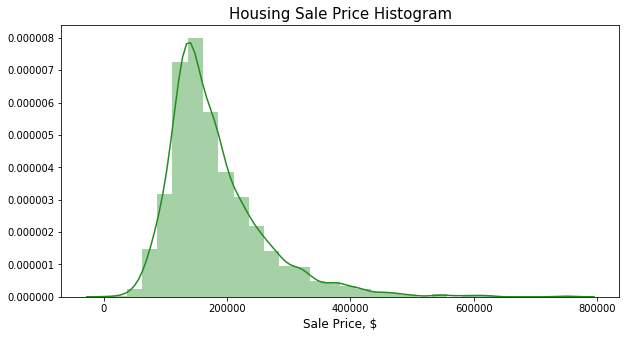

In [11]:
# The right-skew to the SalePrice is obvious in the histogram, showing that SalePrice has a long right tail
fig, ax = plt.subplots(figsize=(10,5))

sns.distplot(df.SalePrice, bins=30, kde=True, ax=ax, color='forestgreen')
plt.title('Housing Sale Price Histogram', fontsize=15)
plt.xlabel('Sale Price, $', fontsize=12)
plt.show()

### property area/size

In [12]:
# One of the chief factors affecting house prices in the size of the property.
# Here we examine the basement square footage variables. 
df[['BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtUnfSF']].head()

,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,BsmtUnfSF
0,639.0,0.0,1080.0,441.0
1,468.0,144.0,882.0,270.0
2,923.0,0.0,1329.0,406.0
3,1065.0,0.0,2110.0,1045.0
4,791.0,0.0,928.0,137.0


In [13]:
# Here we examine the ground square footage variables. The first column is obviously the sum of the other two.
df[['GrLivArea', '1stFlrSF', '2ndFlrSF']].head()

,GrLivArea,1stFlrSF,2ndFlrSF
0,1656.0,1656.0,0.0
1,896.0,896.0,0.0
2,1329.0,1329.0,0.0
3,2110.0,2110.0,0.0
4,1629.0,928.0,701.0


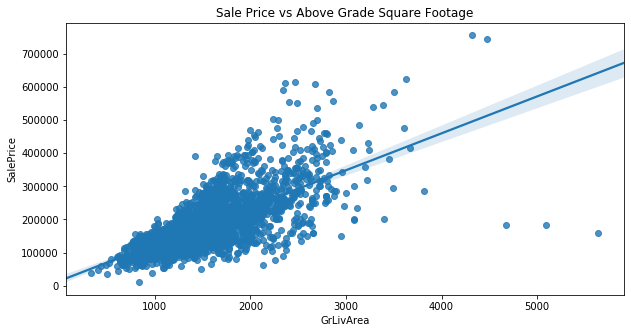

In [14]:
# Clear positive relationship between 'TSF' and 'SalePrice' variables, which is what one would expect.
# The larger the house, the higher its price, ceteris paribus
fig, ax = plt.subplots(figsize=(10,5))

sns.regplot(x="GrLivArea", y="SalePrice", data=df, ax=ax) 
ax.set_title('Sale Price vs Above Grade Square Footage');

In [15]:
df = add_new_features(df)

### Searching for outliers

In [16]:
above_3std_sp = df.SalePrice[(df.SalePrice > np.mean(df.SalePrice) + 3*np.std(df.SalePrice))].count()
under_3std_sp = df.SalePrice[(df.SalePrice < np.mean(df.SalePrice) - 3*np.std(df.SalePrice))].count()
above_3std_ga = df.GrLivArea[(df.GrLivArea > np.mean(df.GrLivArea) + 3*np.std(df.GrLivArea))].count()
under_3std_ga = df.GrLivArea[(df.GrLivArea < np.mean(df.GrLivArea) - 3*np.std(df.GrLivArea))].count()
above_3std_ba = df.BaseLivArea[(df.BaseLivArea > np.mean(df.BaseLivArea) + 3*np.std(df.BaseLivArea))].count()
under_3std_ba = df.BaseLivArea[(df.BaseLivArea < np.mean(df.BaseLivArea) - 3*np.std(df.BaseLivArea))].count()


print(f"instances of 'SalePrice' being 3 std above the mean: {above_3std_sp}")
print(f"(opposite)instances of 'SalePrice' being 3 std under the mean: {under_3std_sp}")
print(f"instances of 'GrLivArea' being 3 std above the mean: {above_3std_ga}")
print(f"(opposite)instances of 'GrLivArea' being 3 std under the mean: {under_3std_ga}")
print(f"instances of 'BaseLivArea' being 3 std above the mean: {above_3std_ba}")
print(f"(opposite)instances of 'BaseLivArea' being 3 std under the mean: {under_3std_ba}")

instances of 'SalePrice' being 3 std above the mean: 45
(opposite)instances of 'SalePrice' being 3 std under the mean: 0
instances of 'GrLivArea' being 3 std above the mean: 25
(opposite)instances of 'GrLivArea' being 3 std under the mean: 0
instances of 'BaseLivArea' being 3 std above the mean: 16
(opposite)instances of 'BaseLivArea' being 3 std under the mean: 0


In [17]:
# transactions listed as "abnormal" or to family members have mean SalePrice well below the overall mean SalePrice
print(df.SalePrice.mean())
print(df.SalePrice[(df.SaleCondition == 'Abnorml') | (df.SaleCondition == 'Family')].mean())

181827.76801103068
147272.08


In [18]:
df_exout = delete_outliers(df)
print(f'deleted outliers: {df.shape[0] - df_exout.shape[0]}')

deleted outliers: 284


### Log transformation of target

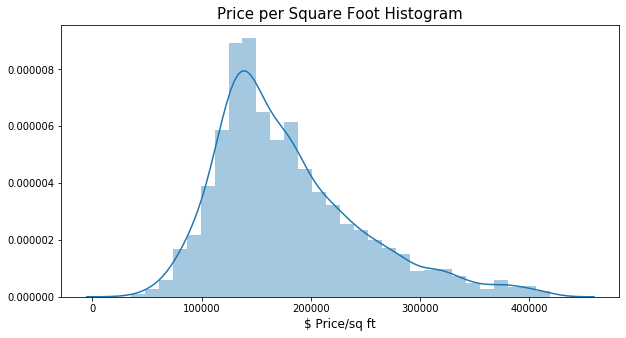

In [19]:
# Despite all the measures above, 'SalePrice' still very much skewed to the right
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df_exout.SalePrice, bins=30, kde=True, ax=ax)
plt.title('Price per Square Foot Histogram', fontsize=15)
plt.xlabel('$ Price/sq ft', fontsize=12);

In [20]:
df_exout = log_target(df_exout)

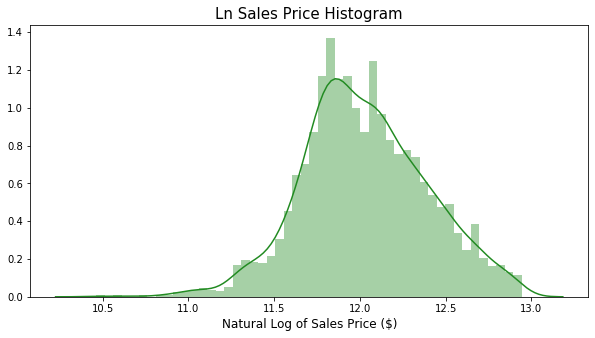

In [21]:
# The histogram of the ln SalePrice is clearly more symmetric
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(df_exout.LnSalePrice, bins=50, kde=True, ax=ax, color='forestgreen')
plt.title('Ln Sales Price Histogram', fontsize=15)
plt.xlabel('Natural Log of Sales Price ($)', fontsize=12);

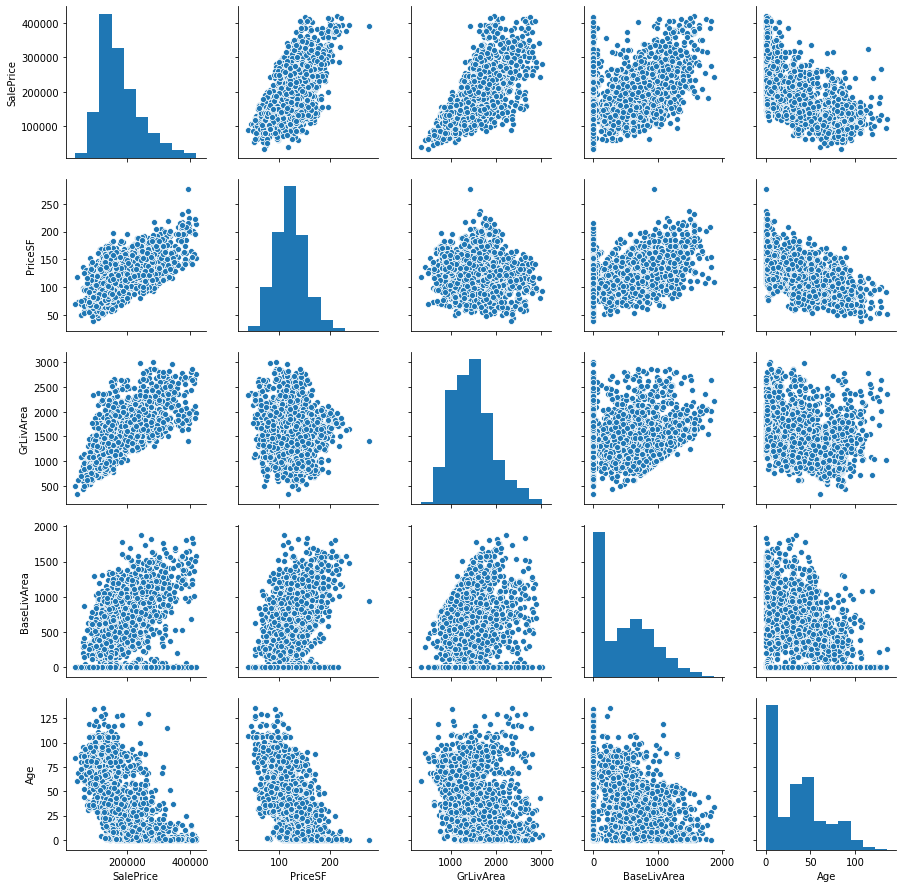

In [22]:
sns.pairplot(df_exout[['SalePrice', 'PriceSF', 'GrLivArea', 'BaseLivArea', 'Age']]);


### Location variable

Examining the 'PriceSF' for the various neighbourhoods, it is obvious that the price premium differs significantly across them

In [23]:
neigh_mean = df_exout['PriceSF'].groupby(df_exout['Neighborhood']).count().sort_values()
print(neigh_mean)
print(len(neigh_mean))

Neighborhood
Landmrk      1
GrnHill      2
Greens       8
Blueste     10
Veenker     21
NPkVill     22
BrDale      26
Blmngtn     28
MeadowV     34
StoneBr     38
ClearCr     38
SWISU       40
IDOTRR      57
NoRidge     60
Timber      66
Crawfor     94
BrkSide     98
Mitchel    103
NWAmes     117
SawyerW    118
Sawyer     137
NridgHt    141
Gilbert    158
Edwards    168
Somerst    173
OldTown    206
CollgCr    257
NAmes      396
Name: PriceSF, dtype: int64
28


Certain **clusters** of neighbourhoods do share similar distributions of 'SalePrice' and/or 'PriceSF'

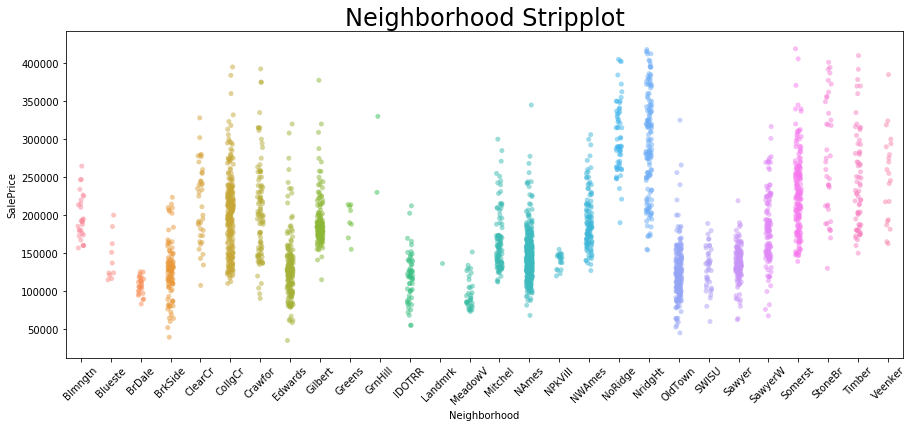

In [24]:
fig, ax = plt.subplots(figsize=(15,6))

sns.stripplot(x = df_exout.Neighborhood, 
              y = df_exout.SalePrice, 
              order = np.sort(df_exout.Neighborhood.unique()),
              jitter=0.1, alpha=0.5, ax=ax)
plt.title('Neighborhood Stripplot', fontsize=24)
plt.xticks(rotation=45)
plt.show()

In [25]:
from houselib import add_location_feature

In [26]:
df_exout = add_location_feature(df_exout)

In [27]:
print(df_exout['OverallQual'].mean())
print(df_exout['OverallCond'].mean())
print(df_exout['ExterQual_Num'].mean())
print(df_exout['ExterCond_Num'].mean())
print(df_exout['Functional_Num'].mean())
print(df_exout.Location.median())

6.103553687428353
5.595338173481085
3.4016048910966754
3.088651127244937
7.858616736721436
2.0


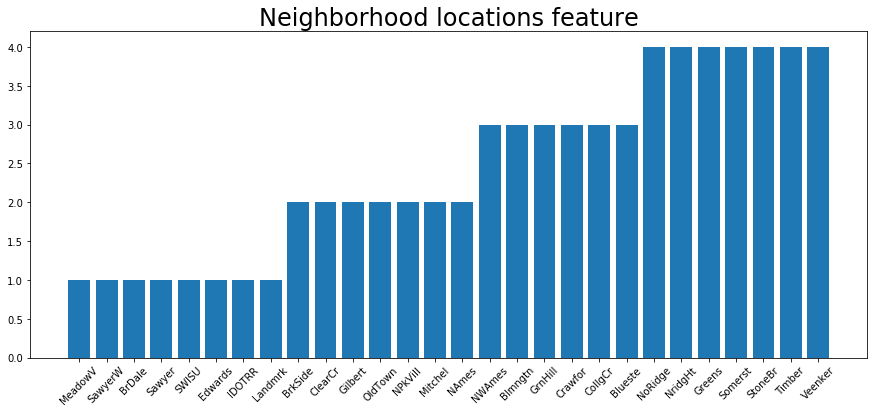

In [28]:
fig, ax = plt.subplots(figsize=(15,6))
location_feature = df_exout['Location'].groupby([df_exout.Neighborhood]).mean().sort_values()
plt.bar(location_feature.keys(), location_feature.values)

plt.title('Neighborhood locations feature', fontsize=24)
plt.xticks(rotation=45)
plt.show()

### sale year, seasonality, zoning, and proximinity to railways & artery roads

'SoldPrice' and 'PriceSF' in 2009 and 2010 are lower than those in 2007 because of the crysis

In [30]:
# Clear price differentials according to the discrete housing zones
df_exout.SalePrice.groupby(df_exout.MSZoning).mean()

MSZoning
FV    220161.447761
RH    130250.000000
RL    186635.804284
RM    128617.762836
Name: SalePrice, dtype: float64

added zoning and year features in add_new_features()

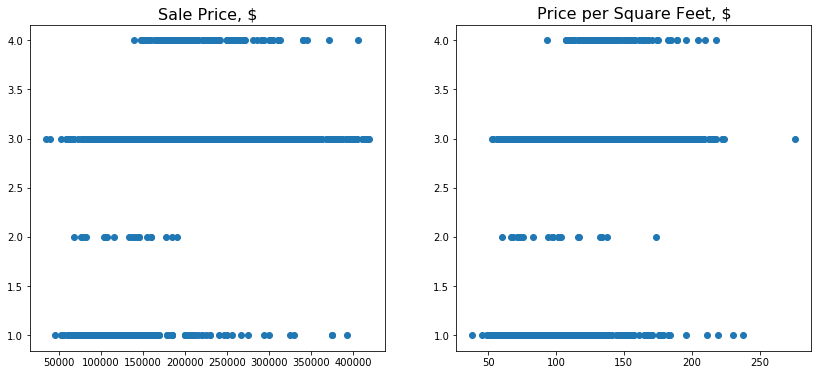

In [31]:
# There is a general increase inprices as we go from Zone 1 to 3, especially in mean 'PriceSF'
fig, ax = plt.subplots(ncols=2, figsize=(14, 6))

ax[0].scatter(df_exout.SalePrice, df_exout.Zone_ordinal)
ax[0].set_title('Sale Price, $', fontsize=16)
ax[1].scatter(df_exout.PriceSF, df_exout.Zone_ordinal)
ax[1].set_title('Price per Square Feet, $', fontsize=16)
#fig.suptitle('Sale Prices by Zone', fontsize=24)
plt.show()

### Make dummy 

In [32]:
df_exout = pd.get_dummies(df_exout, columns=['Street'])
df_exout.drop(['Street_Grvl'], axis=1, inplace=True)
df_exout.rename(columns={'Street_Pave': 'Street_dum'}, inplace=True)
df_exout = pd.get_dummies(df_exout, columns=['KitchenQual'])
# Creating a dummy variable for flat roofs
df_exout['FlatRoof_dum'] = df_exout.RoofStyle.apply(lambda x: 1 if x=='Flat' else 0)
# Creating a dummy variable for garage
df_exout['Garage_dum'] = df_exout.GarageQual.apply(lambda x: 0 if pd.isnull(x)==True else 1)

# Creating a dummy variable for flat property contour
df_exout['FlatContour_dum'] = df_exout.LandContour.apply(lambda x: 1 if x=='Lvl' else 0)
# Creating a dummy variable for houses higher than one storey
df_exout['TwoStory_dum'] = df_exout['2ndFlrSF'].apply(lambda x: 1 if x>0 else 0)

In [43]:
df_exout.GarageArea.isnull()

1

## Save prepared data

In [34]:
df_exout = df_exout[['SalePrice', 'LnSalePrice', 'Age', 'GrLivArea', 'BaseLivArea', 'Location', 
                    'BedroomAbvGr', 'OverallCond', 'OverallQual', 'LotFrontage', 
                     'LotArea', 'TwoStory_dum', 'FlatContour_dum', 'FlatRoof_dum', 'GarageArea', 'Garage_dum', 
                     'CentralAirNum', 'LowQualFinSF', 'Fireplaces', 'KitchenQual_Ex', 'Zoning_2', 'Zoning_3', 
                     'Zoning_4', 'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010']]

In [35]:
df_exout.to_csv('../data/ames_prepared.csv', index=False)